# Import Packages

In [1]:
import os
import glob
import cv2
import numpy as np
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

In [2]:
path  = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'

train_real = os.path.join(path, 'train', 'real')
train_fake = os.path.join(path, 'train', 'fake')
test_real = os.path.join(path, 'test', 'real')
test_fake = os.path.join(path, 'test', 'fake')
valid_real = os.path.join(path, 'valid', 'real')
valid_fake = os.path.join(path, 'valid', 'fake')

allDir = [train_real, train_fake, test_real, test_fake, valid_real, valid_fake]

# Data Cleaning

## Check for duplicate images

In [5]:
import os
import hashlib

def check_for_duplicates(dir_paths):
    # Initialize an empty set to store the hashes of images
    hashes = set()

    # Loop over each directory path
    for dir_path in dir_paths:
        # Loop over each file in the directory
        for file_name in os.listdir(dir_path):
            # Get the path to the file
            file_path = os.path.join(dir_path, file_name)

            # Check if the file is an image
            if file_path.endswith('.jpg') or file_path.endswith('.png'):
                # Calculate the hash of the file's contents
                with open(file_path, 'rb') as f:
                    file_contents = f.read()
                file_hash = hashlib.md5(file_contents).hexdigest()

                # Check if the hash has been seen before
                if file_hash in hashes:
                    print(f'Duplicate file found: {file_path}')
                else:
                    hashes.add(file_hash)

    # Print a message indicating whether any duplicates were found
    if len(hashes) == sum(len(list(os.listdir(dir_path))) for dir_path in dir_paths):
        print('No duplicates found')
    else:
        print('Duplicates found')

# Check all directories for duplicates
check_for_duplicates(allDir)

No duplicates found


# Exploratory Data Analysis

## Filetypes and Image Sizes

In [6]:
import os
from PIL import Image
from tqdm import tqdm

def get_data_summary(dir_list):
    """
    Gets a summary of the data in the specified directories,
    including the filetype and image size.
    
    Args:
    - dir_list: a list of directory paths to analyze
    
    Returns:
    - summary_dict: a dictionary with keys for each filetype and image size
                    and values that are tuples containing the count of images
                    with that filetype and size, respectively
    """
    summary_dict = {}
    
    for directory in dir_list:
        files = os.listdir(directory)
        
        for file in tqdm(files, desc=f"Analyzing {directory}"):
            if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.jpeg'):
                file_path = os.path.join(directory, file)
                img = Image.open(file_path)
                file_type = file.split('.')[-1]
                size = img.size
                
                if file_type not in summary_dict:
                    summary_dict[file_type] = {}
                if size not in summary_dict[file_type]:
                    summary_dict[file_type][size] = 0
                
                summary_dict[file_type][size] += 1
    
    return summary_dict


data_summary = get_data_summary(allDir)
print(data_summary)

Analyzing /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/real: 100%|██████████| 50000/50000 [01:47<00:00, 465.55it/s]
Analyzing /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train/fake: 100%|██████████| 50000/50000 [01:44<00:00, 476.24it/s]
Analyzing /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/real: 100%|██████████| 10000/10000 [00:20<00:00, 492.62it/s]
Analyzing /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test/fake: 100%|██████████| 10000/10000 [00:20<00:00, 484.11it/s]
Analyzing /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/real: 100%|██████████| 10000/10000 [00:20<00:00, 497.27it/s]
Analyzing /kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid/fake: 100%|██████████| 10000/10000 [00:18<00:00, 534.15it/s]

{'jpg': {(256, 256): 140000}}


## Visualise the Images

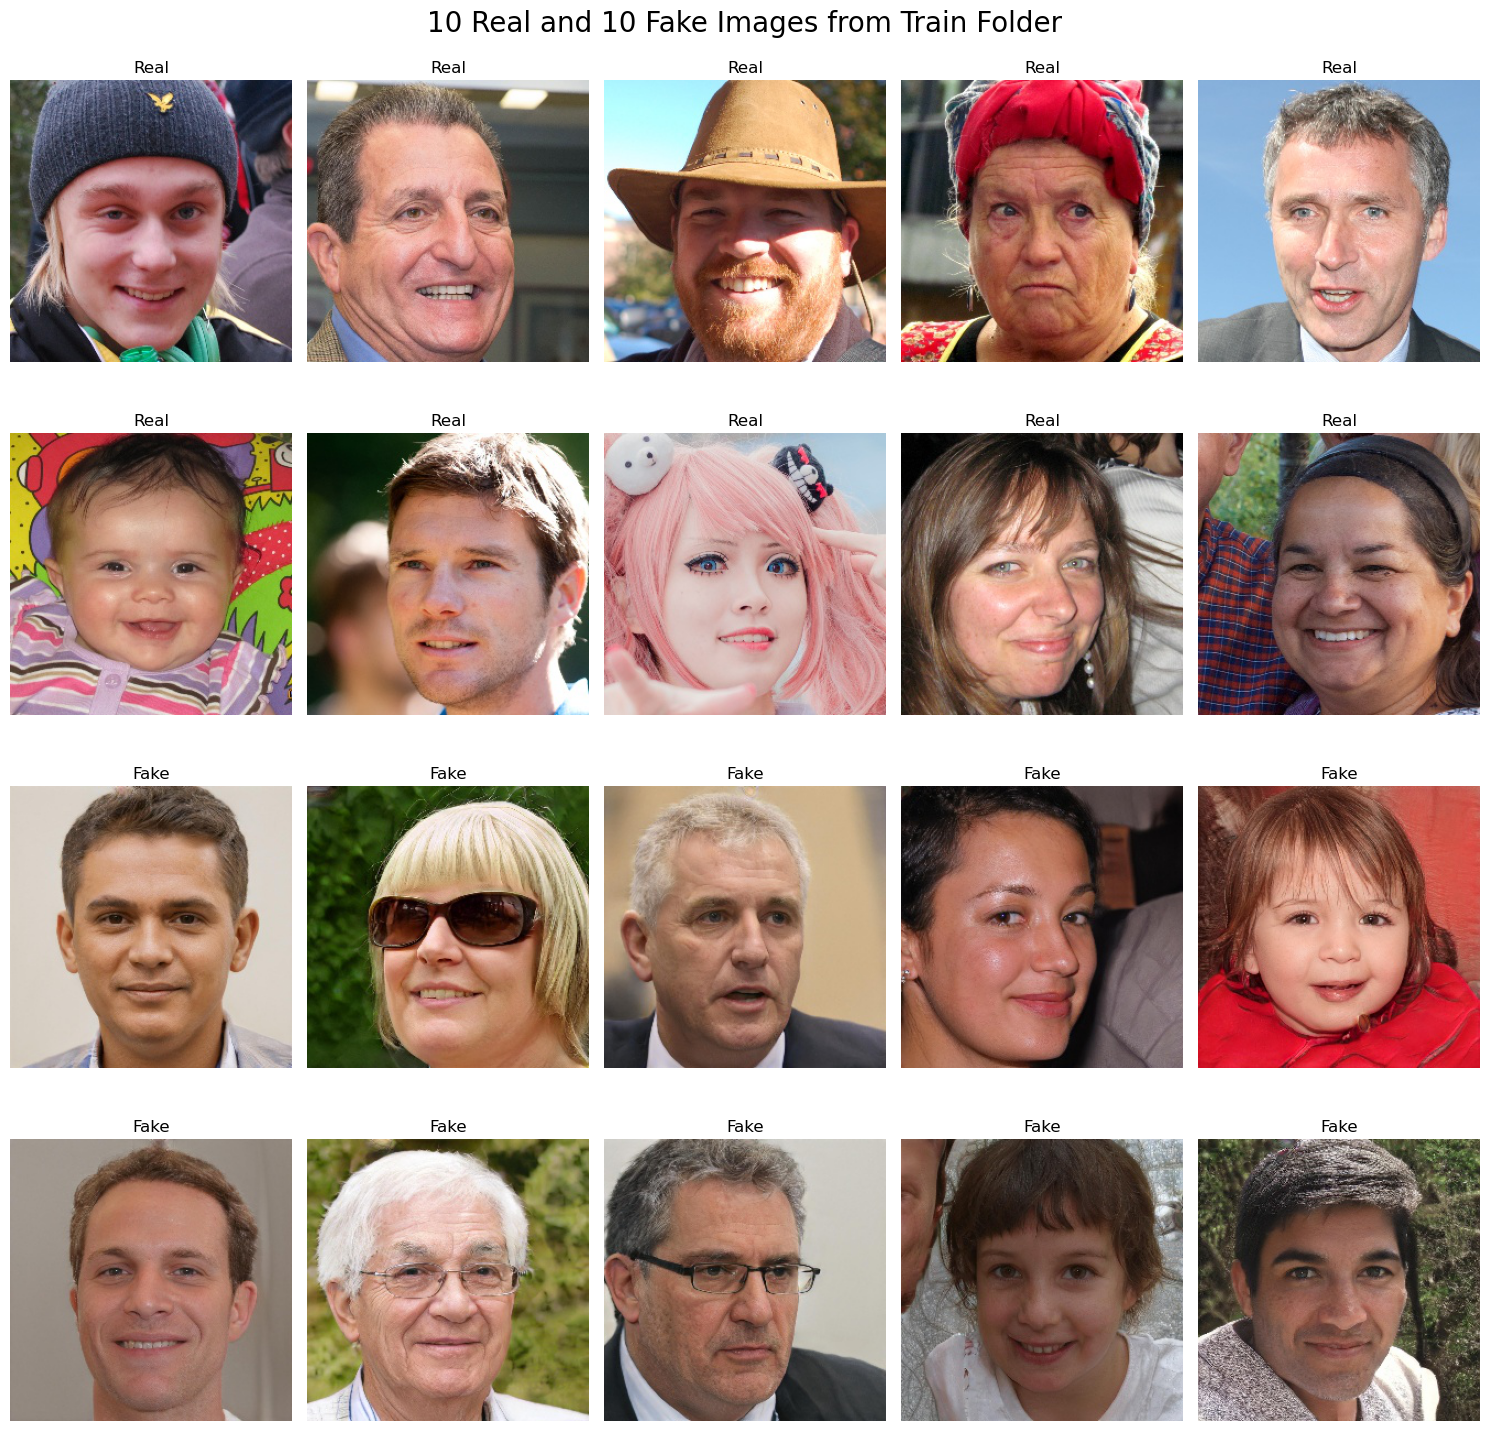

In [7]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set the number of real and fake images to display
num_images = 10

# Create a figure with 4 rows and 5 columns
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15,15))

# Set a header for the figure
fig.suptitle('10 Real and 10 Fake Images from Train Folder', fontsize=20)

# Loop over the real and fake subfolders
for i, subfolder in enumerate(['real', 'fake']):
    
    # Header
    print()

    # Get the path to the subfolder
    subfolder_path = os.path.join(path, "train/"+subfolder)

    # Get a list of image filenames in the subfolder
    image_filenames = os.listdir(subfolder_path)[:num_images]

    # Loop over the image filenames
    for j, image_filename in enumerate(image_filenames):

        # Set the row and column index based on the current loop variables
        row = i*2 + j//5
        col = j%5

        # Get the path to the current image
        image_path = os.path.join(subfolder_path, image_filename)

        # Load and display the image
        image = mpimg.imread(image_path)
        axes[row, col].imshow(image)
        axes[row, col].set_title(subfolder.capitalize())
        axes[row, col].axis('off')

# Adjust the layout and display the figure
fig.tight_layout()
plt.show()

## Check Class Distribution in Train, Test and Validation

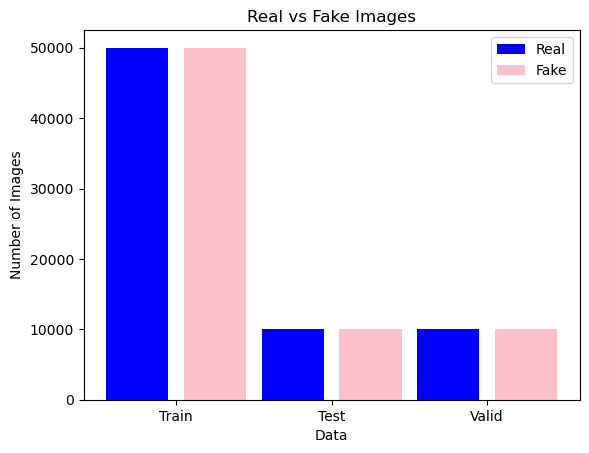

In [11]:
import os
import matplotlib.pyplot as plt

path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'

# count number of images in each folder
train_real_no = len(os.listdir(os.path.join(path, 'train', 'real')))
train_fake_no = len(os.listdir(os.path.join(path, 'train', 'fake')))
rest_real_no = len(os.listdir(os.path.join(path, 'test', 'real')))
test_fake_no = len(os.listdir(os.path.join(path, 'test', 'fake')))
valid_real_no = len(os.listdir(os.path.join(path, 'valid', 'real')))
valid_fake_no = len(os.listdir(os.path.join(path, 'valid', 'fake')))

# create lists for bar plot
train_data = [train_real_no, train_fake_no]
test_data = [rest_real_no, test_fake_no]
valid_data = [valid_real_no, valid_fake_no]

x_labels = ['Train', 'Test', 'Valid']
bar_width = 0.8

# create bar plot with two bars for each dataset (real and fake)
fig, ax = plt.subplots()
train_bars = ax.bar([0, 1], train_data, bar_width, color=['blue', 'pink'])
test_bars = ax.bar([2, 3], test_data, bar_width, color=['blue', 'pink'])
valid_bars = ax.bar([4, 5], valid_data, bar_width, color=['blue', 'pink'])

# add labels and legend
ax.set_xlabel('Data')
ax.set_ylabel('Number of Images')
ax.set_title('Real vs Fake Images')
ax.set_xticks([0.5, 2.5, 4.5])
ax.set_xticklabels(x_labels)
ax.legend((train_bars[0], train_bars[1]), ('Real', 'Fake'))

plt.show()

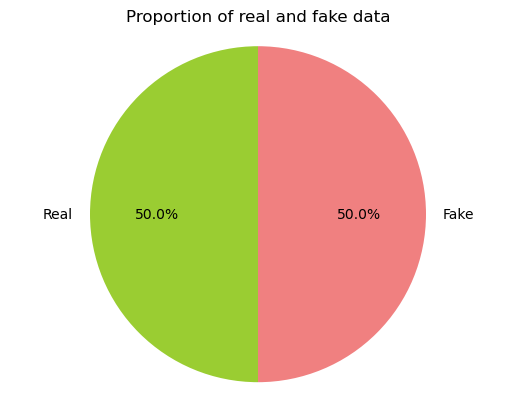

In [13]:
# Proportion of each category
import matplotlib.pyplot as plt

count1 = train_real_no
count2 = train_fake_no

labels = ['Real', 'Fake']
sizes = [count1, count2]
colors = ['yellowgreen', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=90)

plt.title("Proportion of real and fake data")
plt.axis('equal')
plt.show()

Data is balanced across the two classes in the training set, and will not be biased towards the majority class. No techniques for data balancing required.

# Data Preparation

### Data Augmentation and Data Normalisation

In [3]:
image_gen = ImageDataGenerator(rescale=1./255)

In [4]:
# Augment Trainset data
train_generator = ImageDataGenerator(rescale=1./255,shear_range=10, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1).flow_from_directory(
    path + 'train/',
    target_size=(224, 224),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 100000 images belonging to 2 classes.


In [5]:
# Augment Validation data
valid_generator = image_gen.flow_from_directory(
    path + 'valid/',
    target_size=(224, 224),
    batch_size=100,
    color_mode='grayscale',
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


In [6]:
# Augment Testing data
test_generator = image_gen.flow_from_directory(
    path + 'test/',
    target_size=(224, 224),
    batch_size=100,
    shuffle=False,
    color_mode='grayscale',
    class_mode='binary'
)

Found 20000 images belonging to 2 classes.


# Data Model 1: Custom Neural Network

## Build the Model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# define the model
model = Sequential()

# add convolutional layers
# Input Layer defined as (Pixel Width, Pixel Height, Color Channels). Color Channel is set to 1, because image is grayscale
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten the output from the convolutional layers
model.add(Flatten())

# add dense layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

## Compile the Model

In [13]:
## Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

## Train the model

In [15]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = (100000//100),
    validation_data = valid_generator,
    validation_steps = (20000//100),
    epochs = 10
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
1000/1000 [==============================] - 1405s 1s/step - loss: 0.6579 - accuracy: 0.6044 - val_loss: 0.5988 - val_accuracy: 0.6811
Epoch 2/10
1000/1000 [==============================] - 753s 753ms/step - loss: 0.5952 - accuracy: 0.6847 - val_loss: 0.5627 - val_accuracy: 0.7099
Epoch 3/10
1000/1000 [==============================] - 707s 707ms/step - loss: 0.5395 - accuracy: 0.7317 - val_loss: 0.4882 - val_accuracy: 0.7642
Epoch 4/10
1000/1000 [==============================] - 719s 719ms/step - loss: 0.4900 - accuracy: 0.7662 - val_loss: 0.4349 - val_accuracy: 0.8014
Epoch 5/10
1000/1000 [==============================] - 723s 723ms/step - loss: 0.4490 - accuracy: 0.7922 - val_loss: 0.4441 - val_accuracy: 0.7937
Epoch 6/10
1000/1000 [==============================] - 742s 742ms/step - loss: 0.4194 - accuracy: 0.8095 - val_loss: 0.3857 - val_accuracy: 0.8224
Epoch 7/10
1000/1000 [==============================] - 761s 761ms/step - loss: 0.3900 - accuracy: 0.8266 - val_lo

<AxesSubplot:>

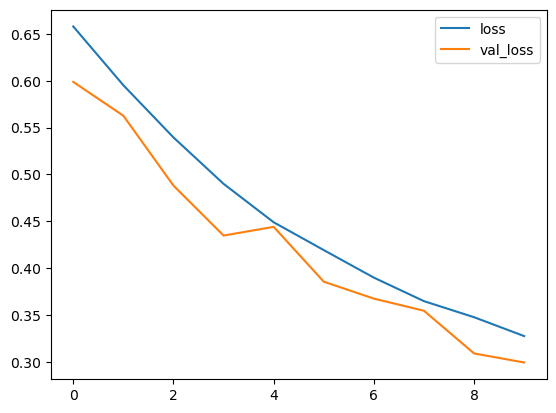

In [17]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

<AxesSubplot:>

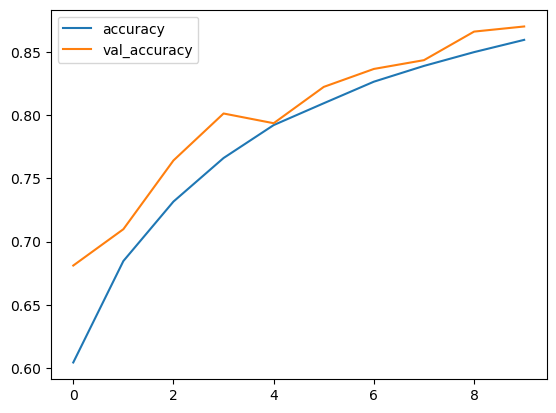

In [18]:
losses[['accuracy','val_accuracy']].plot()

## Test the model

In [19]:
# assume model is your trained Keras model and test_generator is your test dataset generator
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

200/200 [==============================] - 200s 1s/step - loss: 0.2923 - accuracy: 0.8750
Test accuracy: 0.875


200/200 [==============================] - 66s 331ms/step


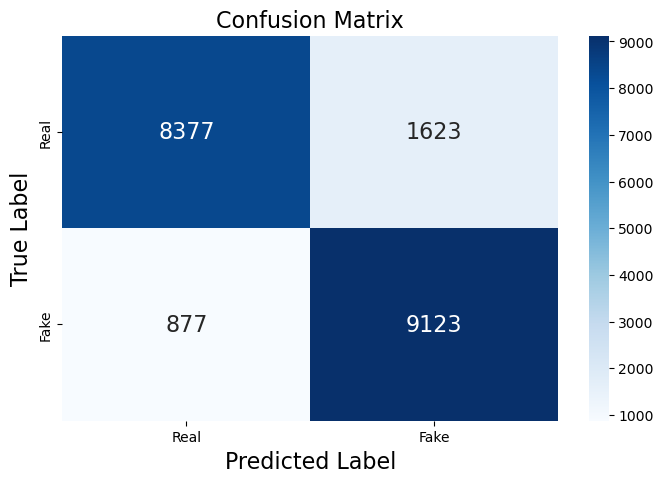

True Positive: 9123
True Negative: 8377
False Positive: 1623
False Negative: 877
Prediction accuracy: 87.50%
Precision: 84.90%
Recall: 91.23%
F1-Score: 87.95%
False Positive Rate: 16.23%
False Negative Rate: 8.77%


In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_generator.reset()

# assume model is your trained Keras model and test_generator is your test dataset generator
y_pred = model.predict(test_generator)

# Get the true labels and predictions
y_true = test_generator.classes

# Swap the labels
y_true = 1 - y_true
y_pred = 1 - y_pred

# Apply thresholding
y_pred_thresh = np.where(y_pred >= 0.5, 1, 0)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_thresh)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'], annot_kws={"fontsize":16})
plt.xlabel('Predicted Label',fontsize=16)
plt.ylabel('True Label',fontsize=16)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Compute the classification report
# target_names = ['Real', 'Fake']
# print(classification_report(y_true, y_pred_thresh, target_names=target_names))

# Calculate metrics
tp = cm[1][1]
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
total = tp + tn + fp + fn

accuracy = (tp + tn) / total
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

# Display results
print('True Positive:', tp)
print('True Negative:', tn)
print('False Positive:', fp)
print('False Negative:', fn)
print('Prediction accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1-Score: {:.2f}%'.format(f1_score * 100))
print('False Positive Rate: {:.2f}%'.format(false_positive_rate * 100))
print('False Negative Rate: {:.2f}%'.format(false_negative_rate * 100))

In [21]:
# Save the model
model.save('model.h5')

# Download the model file
from IPython.display import FileLink
FileLink('model.h5')

/kaggle/working/model.h5

In [17]:
from tensorflow.keras.models import load_model

# Load the model from a saved file
model = load_model('/kaggle/working/model.h5')

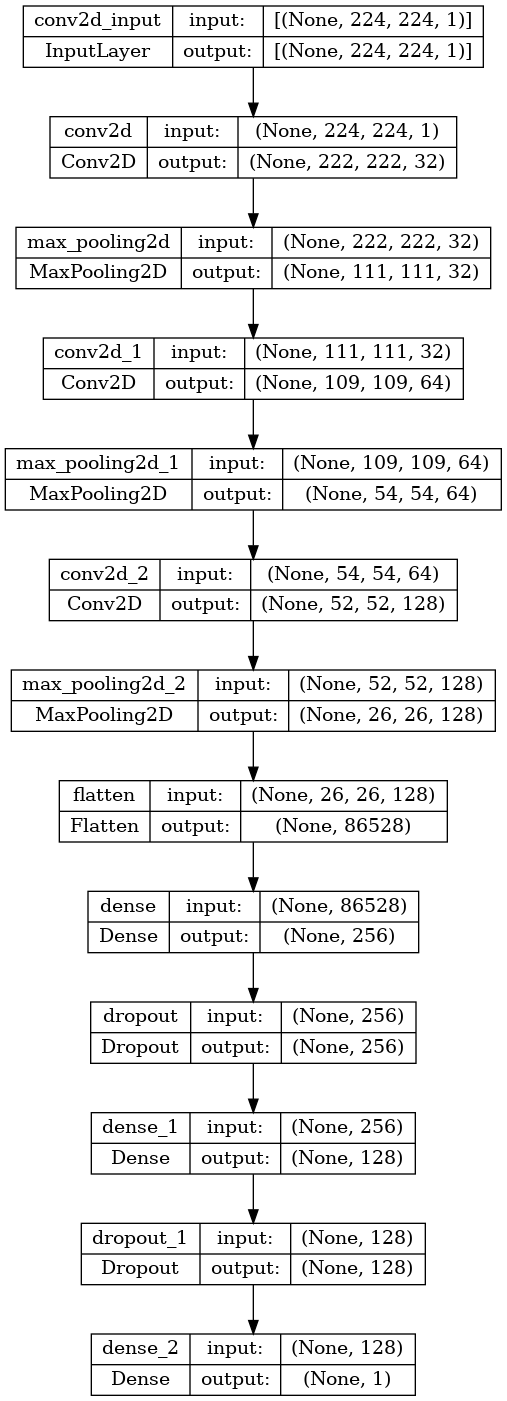

In [24]:
from keras.utils.vis_utils import plot_model

# plot the model architecture
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Data Model 2：Pre-Trained Neural Network

In [7]:
densenet = DenseNet121( weights=None, include_top=False, input_shape=(224,224,1) )

model2 = Sequential([ 
        densenet,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1, activation='sigmoid')
    ])

## Compile the Model

In [8]:
model2.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [9]:
# Model Summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7031232   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,032,257
Trainable params: 6,948,609
Non-trainable params: 83,648
_________________________________________________________________


## Train the Model

In [10]:
history2 = model2.fit_generator(
    train_generator,
    steps_per_epoch = (100000//100),
    validation_data = valid_generator,
    validation_steps = (20000//100),
    epochs = 10
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
1000/1000 [==============================] - 1450s 1s/step - loss: 0.5753 - accuracy: 0.6950 - val_loss: 0.8225 - val_accuracy: 0.6694
Epoch 2/10
1000/1000 [==============================] - 1180s 1s/step - loss: 0.4008 - accuracy: 0.8169 - val_loss: 0.5105 - val_accuracy: 0.7887
Epoch 3/10
1000/1000 [==============================] - 1245s 1s/step - loss: 0.2807 - accuracy: 0.8822 - val_loss: 0.3079 - val_accuracy: 0.8684
Epoch 4/10
1000/1000 [==============================] - 1183s 1s/step - loss: 0.1931 - accuracy: 0.9218 - val_loss: 0.7501 - val_accuracy: 0.6762
Epoch 5/10
1000/1000 [==============================] - 1177s 1s/step - loss: 0.1415 - accuracy: 0.9442 - val_loss: 0.2382 - val_accuracy: 0.9048
Epoch 6/10
1000/1000 [==============================] - 1177s 1s/step - loss: 0.1054 - accuracy: 0.9593 - val_loss: 0.1983 - val_accuracy: 0.9250
Epoch 7/10
1000/1000 [==============================] - 1175s 1s/step - loss: 0.0871 - accuracy: 0.9667 - val_loss: 0.1483 -

In [12]:
# Save the model
model2.save('model2.h5')

# Download the model file
from IPython.display import FileLink
FileLink('model2.h5')

/kaggle/working/model2.h5

<AxesSubplot:>

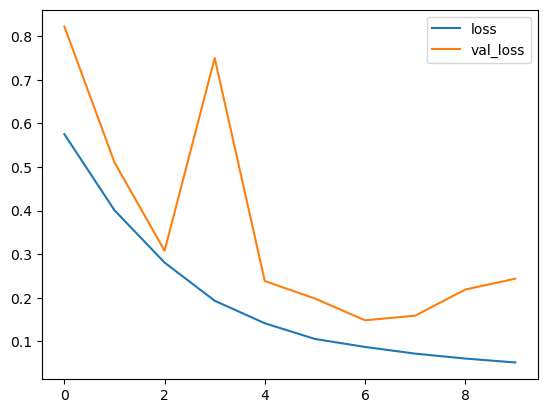

In [13]:
losses2 = pd.DataFrame(model2.history.history)
losses2[['loss','val_loss']].plot()

<AxesSubplot:>

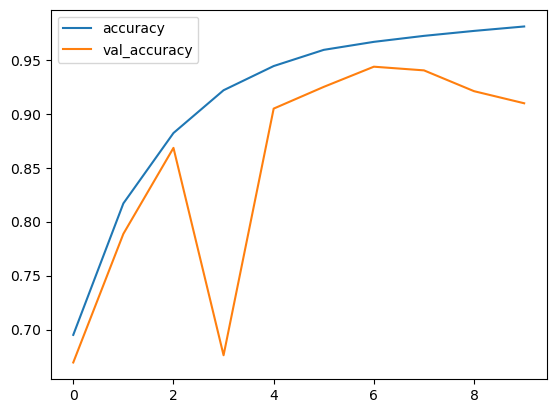

In [14]:
losses2[['accuracy','val_accuracy']].plot()

## Test the Model

In [15]:
# assume model is your trained Keras model and test_generator is your test dataset generator
test_loss2, test_acc2 = model2.evaluate(test_generator)
print('Test accuracy:', test_acc2)

200/200 [==============================] - 190s 953ms/step - loss: 0.2377 - accuracy: 0.9112
Test accuracy: 0.9112499952316284


200/200 [==============================] - 64s 308ms/step


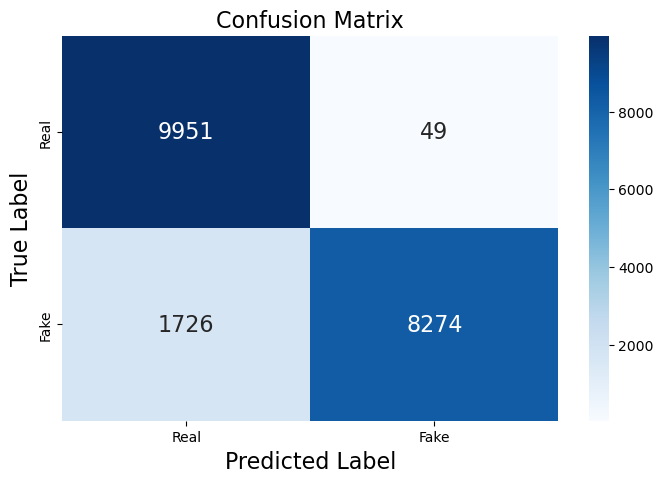

True Positive: 8274
True Negative: 9951
False Positive: 49
False Negative: 1726
Prediction accuracy: 91.12%
Precision: 99.41%
Recall: 82.74%
F1-Score: 90.31%
False Positive Rate: 0.49%
False Negative Rate: 17.26%


In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_generator.reset()

# assume model is your trained Keras model and test_generator is your test dataset generator
y_pred = model2.predict(test_generator)

# Get the true labels and predictions
y_true = test_generator.classes

# Swap the labels
y_true = 1 - y_true
y_pred = 1 - y_pred

# Apply thresholding
y_pred_thresh = np.where(y_pred >= 0.5, 1, 0)

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_thresh)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'], annot_kws={"fontsize":16})
plt.xlabel('Predicted Label',fontsize=16)
plt.ylabel('True Label',fontsize=16)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Compute the classification report
# target_names = ['Real', 'Fake']
# print(classification_report(y_true, y_pred_thresh, target_names=target_names))

# Calculate metrics
tp = cm[1][1]
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
total = tp + tn + fp + fn

accuracy = (tp + tn) / total
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * precision * recall / (precision + recall)
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

# Display results
print('True Positive:', tp)
print('True Negative:', tn)
print('False Positive:', fp)
print('False Negative:', fn)
print('Prediction accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1-Score: {:.2f}%'.format(f1_score * 100))
print('False Positive Rate: {:.2f}%'.format(false_positive_rate * 100))
print('False Negative Rate: {:.2f}%'.format(false_negative_rate * 100))

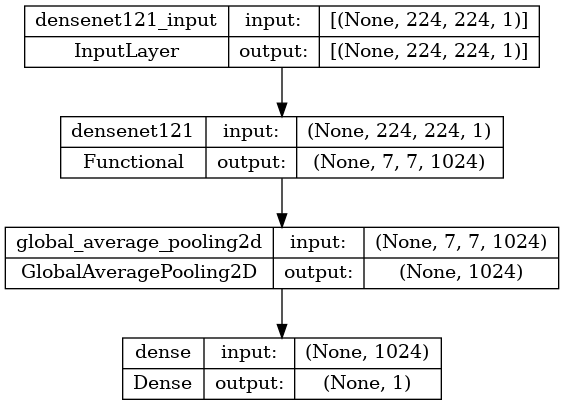

In [17]:
from keras.utils.vis_utils import plot_model

# plot the model architecture
plot_model(model2, to_file='model2.png', show_shapes=True, show_layer_names=True)